# Climate Analysis and Exploration

## Background 

A climate analysis and exploration of the precipitation and temperature from a variety of stations is done on Honolulu, HI. 

#### Import Python and SQL Alchemy Libraries

In [290]:
#Python Libraries
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import time

output_image = 'Images/Precipitation_Figure.png'
output_image2 = 'Images/TempFreqHis.png'
output_image3 = 'Images/TripAvgTemp.png'

In [ ]:
# SQL Alchemy Libraries
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

#### Create the engine from the database path 

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#### Reflect an existing database into a new model

In [ ]:
Base = automap_base()

#### Reflect the table and create a session link

In [ ]:
Base.prepare(engine, reflect=True)
session = Session(engine)

#### Viewing all of the classes that automap found

In [ ]:
Base.classes.keys()

#### Save references to each table

In [ ]:
Station = Base.classes.station
Measurement = Base.classes.measurement

## Exploratory Climate Analysis

### Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

#### Order the query by descending order to find the most recent date

In [ ]:
Recent_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(10).all()
Last_Date = Recent_Date[0][0]

#### Find the value 12 months before the most recent date to get the range of interest

In [ ]:
Last_Unix = time.mktime(datetime.datetime.strptime(Last_Date,"%Y-%m-%d").timetuple())
First_Unix = round(Last_Unix - 31500000)
First_Date = datetime.datetime.fromtimestamp(First_Unix).strftime('%Y-%m-%d')

#### Filter the data to show only dates after 08-23-2016 and convert to a pandas dataframe

In [ ]:
Twelve_Month_Query = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= First_Date).all(),
                                 columns = ['Date','Precipitation'])

#### Set the index to the date column and sort the dataframe by date

In [ ]:
Twelve_Month_Query.set_index('Date', inplace=True)
Twelve_Month_Query_df = Twelve_Month_Query.sort_values(by='Date',ascending=True)

#### Use Pandas Plotting with Matplotlib to plot the data and print a summary of the dataframe

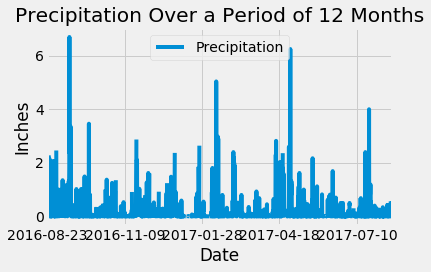

In [288]:
Twelve_Month_Query_df.plot()
plt.title('Precipitation Over a Period of 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.savefig(output_image)
plt.tight_layout()
plt.show()

In [ ]:
Twelve_Month_Query_df.describe()

### Station Analysis

### Design a query to show how many stations are available in this dataset?

In [174]:
Station_Count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"The number of stations are {Station_Count}")

The number of stations are 9


### What are the most active stations?

#### List the stations and the counts in descending order.

In [200]:
Station_list = session.query(Measurement.station).group_by(Measurement.station).all()
stations = [] 
station_count = []

for i in Station_list:
    i_dict = i._asdict()  # sqlalchemy.util._collections.result , has a method called _asdict()
    stations.append(i_dict)
    
for index in range(len(stations)): 
    station_count.append([session.query(Measurement).filter(Measurement.station == stations[index]['station']).count(), 
                         Station_list[index]])

Station_Desc = sorted(station_count , reverse = True)

print('The most active stations are')
Station_Desc

The most active stations are


[[2772, ('USC00519281')],
 [2724, ('USC00519397')],
 [2709, ('USC00513117')],
 [2669, ('USC00519523')],
 [2612, ('USC00516128')],
 [2202, ('USC00514830')],
 [1979, ('USC00511918')],
 [1372, ('USC00517948')],
 [511, ('USC00518838')]]

### Using the station id from the previous query, calculate the lowest temperature recorded,  highest temperature recorded, and average temperature of the most active station?

In [221]:
active_station = Station_Desc[0][1] 
active_dict = active_station._asdict()
func_active_station = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),
                                    func.avg(Measurement.tobs).filter(Measurement.station == active_dict['station'])).all() 

In [227]:
print(f'The lowest temperature recorded for the most active station is {func_active_station[0][0]}')

The lowest temperature recorded for the most active station is 53.0


In [228]:
print(f'The highest temperature recorded for the most active station is {func_active_station[0][1]}')

The highest temperature recorded for the most active station is 87.0


In [230]:
print(f'The average temperature recorded for the most active station is {round(func_active_station[0][2],2)}')

The average temperature recorded for the most active station is 71.66


### Design a query to retrieve the last 12 months of temperature observation data (TOBS).

#### Filter by the station with the highest number of observations.

In [233]:
Temp_Station = session.query(Measurement.station, 
                             func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
Max_Temp_Station= Temp_Station[0]

#### Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [237]:
Twelve_Temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= First_Date).filter(Measurement.station == Max_Temp_Station).all()
Twelve_Temp_df = pd.DataFrame(Twelve_Temp,columns = ['Date','Temperature'])                

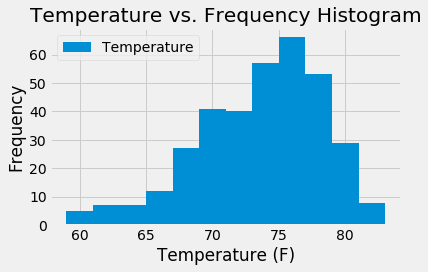

In [291]:
Twelve_Temp_df.plot.hist(bins=12) 
plt.title("Temperature vs. Frequency Histogram")
plt.xlabel('Temperature (F)')
plt.savefig(output_image2)
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment 

In [243]:
 # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [244]:
Start_Date_Vac = "2015-06-10"
End_Date_Vac = "2015-07-15"

Start_Date_Vac_Unix = time.mktime(datetime.datetime.strptime(Start_Date_Vac,"%Y-%m-%d").timetuple())
Start_Date_Unix = round(Start_Date_Vac_Unix - 31500000)
First_Date_Vac = datetime.datetime.fromtimestamp(Start_Date_Unix).strftime('%Y-%m-%d')

End_Date_Vac_Unix = time.mktime(datetime.datetime.strptime(End_Date_Vac,"%Y-%m-%d").timetuple())
End_Date_Unix = round(End_Date_Vac_Unix - 31500000)
Last_Date_Vac = datetime.datetime.fromtimestamp(End_Date_Unix).strftime('%Y-%m-%d')

In [252]:
Vac_Averages = calc_temps(First_Date_Vac,Last_Date_Vac)
Min_temp = Vac_Averages[0][0]
Average_temp = Vac_Averages[0][1]
Max_temp = Vac_Averages[0][2]
print(Vac_Averages)

[(68.0, 75.4618320610687, 84.0)]


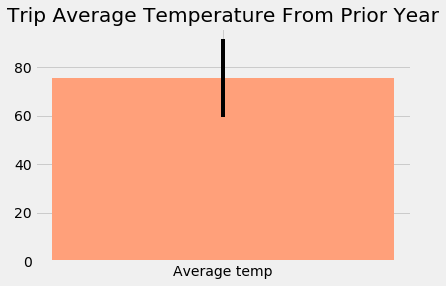

In [297]:
yerror = [Min_temp,Max_temp]
bar_chart = plt.bar(1 , Average_temp, color= 'lightsalmon',
                   align='center',tick_label = 'Average temp',
                   yerr = yerror[1]-yerror[0])
plt.title('Trip Average Temperature From Prior Year')
plt.savefig(output_image2)
# fig.set_size_inches(2.5, 5)
# fig.tight_layout()
plt.show()